In [322]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx
# mawrer@gmail.com

import numpy as np
np.random.seed(1)

#Tensorflow
import tensorflow as tf
tf.random.set_seed(2)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

#Pandas
import pandas as pd 

#Keras
from keras import backend as K
from keras import metrics
from keras.callbacks import ModelCheckpoint
from keras.layers import Activation, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

#Statistics Libraries
from statsmodels.tsa.arima_model import ARIMA
from scipy import stats
import math as m

#plots
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure

#OverSampling
from imblearn.over_sampling import RandomOverSampler

#SKlearn
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder

#global
import os, glob

In [323]:
import warnings
warnings.filterwarnings("ignore")

In [324]:
ID = "01"
MODEL_NAME = "C-LSTM"
NUM_FEATURES = 0
TARGET_NAME = "Class"
FRECUENCIA = "1H"
MSE_RESULT = 0

In [325]:
RANGE = 24

HYPER_L1_IN = RANGE
EPOCHS = 100
BATCH_SIZE = 32

TEST_SIZE = .20
VAL_SIZE = .10

START_IN = 0

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [326]:
pwd = os.getcwd()
datasource_path = os.path.join(pwd, r'../../../Datasets/Junio2020/procesados_classification/')
filenames = glob.glob(datasource_path + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

C-EURUSD_FULL_1D_21F.csv
C-EURUSD_FULL_1H_25F.csv


In [327]:
if FRECUENCIA =="1D":
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d')
else:
    dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
DATASET = pd.read_csv(filenames[1], header=0, parse_dates=['Gmt time'], date_parser=dateparse)
DATASET.head()


,Gmt time,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,...,Pct_Range_Close_diff,MA_Close_5,MA_Close_25,MA_Close_50,MA_Close_200,Class,Sell,Sell2,Buy,Buy2
0,2004-01-01 00:00:00,1.25950,1.25960,1.25826,1.25910,6654.2002,1.25934,1.25948,1.25814,1.25900,...,0.000000,0.000000,0.0,0.0,0.0,1.0,NaN,NaN,1.25910,NaN
1,2004-01-01 01:00:00,1.25958,1.25960,1.25947,1.25951,660.6000,1.25942,1.25948,1.25934,1.25941,...,0.000326,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,2004-01-01 02:00:00,1.25955,1.25962,1.25944,1.25951,2091.0000,1.25945,1.25948,1.25927,1.25936,...,-0.000326,0.000000,0.0,0.0,0.0,-1.0,1.25951,NaN,NaN,NaN
3,2004-01-01 03:00:00,1.25950,1.25965,1.25834,1.25869,10003.0996,1.25934,1.25953,1.25821,1.25854,...,-0.000651,0.000000,0.0,0.0,0.0,1.0,NaN,NaN,1.25869,NaN
4,2004-01-01 04:00:00,1.25908,1.25960,1.25843,1.25950,7603.3999,1.25898,1.25948,1.25829,1.25940,...,0.001295,1.259262,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [328]:
#Describe DATASET
print('Shape: ', DATASET.shape)
print(DATASET.describe())
DATASET = DATASET.drop(['day_name'], axis = 1)
DATASET = DATASET.drop(['Gmt time'], axis = 1)
print(DATASET.dtypes)


Shape:  (102514, 25)
                Open           High            Low          Close  \
count  102514.000000  102514.000000  102514.000000  102514.000000   
mean        1.264046       1.265085       1.263008       1.264047   
std         0.122828       0.123008       0.122629       0.122829   
min         1.035600       1.037040       1.034050       1.035630   
25%         1.149838       1.150705       1.149015       1.149833   
50%         1.270655       1.271820       1.269425       1.270670   
75%         1.350917       1.352038       1.349740       1.350920   
max         1.601460       1.604030       1.598830       1.601570   

              Volume       Open_Bid       High_Bid        Low_Bid  \
count  102514.000000  102514.000000  102514.000000  102514.000000   
mean    20711.113359       1.263956       1.265001       1.262923   
std     32706.529958       0.122803       0.122983       0.122604   
min         0.380000       1.035580       1.037020       1.034030   
25%      498

In [329]:
DF_Full = DATASET[199:]
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
print(DF_Full.head())

(102315, 23)
      Open     High      Low    Close      Volume  Open_Bid  High_Bid  \
0  1.27584  1.27666  1.27351  1.27436  25980.0000   1.27580   1.27649   
1  1.27435  1.27891  1.27331  1.27891  24881.5996   1.27419   1.27884   
2  1.27890  1.27957  1.27550  1.27552  24909.9004   1.27880   1.27947   
3  1.27523  1.27566  1.27374  1.27462  26329.6992   1.27513   1.27555   
4  1.27465  1.27482  1.27195  1.27277  25984.5000   1.27449   1.27467   

   Low_Bid  Close_Bid  Volume_Bid  ...  Pct_Range_Close_diff  MA_Close_5  \
0  1.27341    1.27426  30272.0996  ...             -0.001270    1.275586   
1  1.27318    1.27871  28934.9004  ...              0.004746    1.276222   
2  1.27536    1.27538  32662.0000  ...             -0.006221    1.276078   
3  1.27358    1.27452  31190.5996  ...              0.001945    1.275854   
4  1.27184    1.27262  32288.5996  ...             -0.000746    1.275236   

   MA_Close_25  MA_Close_50  MA_Close_200  Class     Sell    Sell2  Buy  \
0     1.278516  

In [330]:
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)

Total:  102315
Start:  0


In [331]:
#Shape the first START of the total
DF_Full = DF_Full.iloc[START_IN:]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
NUM_FEATURES = DF_Full.shape[1]
print(DF_Full.shape)

(102315, 23)


In [332]:

total = DATASET.shape[0]
print('Total: ', total)

Total:  102514


In [333]:
DF_Full[TARGET_NAME][0:12]

0     2.0
1    -2.0
2    -1.0
3    -2.0
4     2.0
5     0.0
6     2.0
7     2.0
8    -2.0
9     0.0
10    2.0
11    0.0
Name: Class, dtype: float64

### Generate VECTOR Y

In [334]:
#generate the VECTOR Y
uniques, ids = np.unique(DF_Full[TARGET_NAME], return_inverse=True)
print(ids)
#target_y = np_utils.to_categorical(DF_Full[TARGET_NAME],num_classes=5)
target_y = np_utils.to_categorical(ids,len(uniques))

[4 0 1 ... 2 3 2]


In [335]:
close_y = target_y
print(close_y[:10])   
#   [1. 0. 0. 0. 0.]   =  0
#   [0. 1. 0. 0. 0.]   =  1
#   [0. 0. 1. 0. 0.]   =   2 
#   [0. 0. 0. 1. 0.]   =  -2
#   [0. 0. 0. 0. 1.]   =  -1
close_y.shape

[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]


(102315, 5)

### REMOVE COLUMNS 

In [336]:
#REMOVE CLASS FROM Data
print(DF_Full.shape)
DF_Full = DF_Full.drop(['Class'], axis = 1)
DF_Full = DF_Full.drop(['Buy'], axis = 1)
DF_Full = DF_Full.drop(['Buy2'], axis = 1)
DF_Full = DF_Full.drop(['Sell'], axis = 1)
DF_Full = DF_Full.drop(['Sell2'], axis = 1)
DF_Full.reset_index(drop=True, inplace=True)
print(DF_Full.shape)
DF_Full.head()

(102315, 23)
(102315, 18)


,Open,High,Low,Close,Volume,Open_Bid,High_Bid,Low_Bid,Close_Bid,Volume_Bid,Spread,weekday,Pct_Range_Close,Pct_Range_Close_diff,MA_Close_5,MA_Close_25,MA_Close_50,MA_Close_200
0,1.27584,1.27666,1.27351,1.27436,25980.0000,1.27580,1.27649,1.27341,1.27426,30272.0996,0.00010,1,-0.001176,-0.001270,1.275586,1.278516,1.279646,1.269048
1,1.27435,1.27891,1.27331,1.27891,24881.5996,1.27419,1.27884,1.27318,1.27871,28934.9004,0.00020,1,0.003570,0.004746,1.276222,1.278232,1.279762,1.269147
2,1.27890,1.27957,1.27550,1.27552,24909.9004,1.27880,1.27947,1.27536,1.27538,32662.0000,0.00014,1,-0.002651,-0.006221,1.276078,1.277701,1.279831,1.269227
3,1.27523,1.27566,1.27374,1.27462,26329.6992,1.27513,1.27555,1.27358,1.27452,31190.5996,0.00010,1,-0.000706,0.001945,1.275854,1.277153,1.279893,1.269302
4,1.27465,1.27482,1.27195,1.27277,25984.5000,1.27449,1.27467,1.27184,1.27262,32288.5996,0.00015,1,-0.001451,-0.000746,1.275236,1.276572,1.279881,1.269373


### SPLIT in 3 Sub Datasets

In [165]:
s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.30000000000000004
count of Val and Test: 30754
end of train:  71760
count val:  10251
count test:  20502
end_val 82011


In [166]:
close_y[:end_train,:]

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [271]:
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print("data_training.shape: ",data_training.shape)
print("data_val.shape: ", data_val.shape)
print("data_test.shape: ", data_test.shape)

data_training_y = close_y[:end_train,:]
data_val_y = close_y[end_train: end_val,:]
data_test_y = close_y[end_val:,:]

print("data_training_y.shape: ", data_training_y.shape)
print("data_val_y.shape: ", data_val_y.shape)
print("data_test_y.shape: ", data_test_y.shape)

data_training.shape:  (71760, 18)
data_val.shape:  (10251, 18)
data_test.shape:  (20304, 18)
data_training_y.shape:  (71760, 5)
data_val_y.shape:  (10251, 5)
data_test_y.shape:  (20304, 5)


In [168]:
data_test['Close'].head(10)

82011    1.05892
82012    1.05958
82013    1.05765
82014    1.05935
82015    1.05927
82016    1.06081
82017    1.06089
82018    1.06139
82019    1.05724
82020    1.05668
Name: Close, dtype: float64

In [125]:
uniques_data_test_y = uniques[data_test_y.argmax(1)]
uniques_data_test_y[:10]

array([ 1., -2.,  2.,  0.,  2.,  0.,  1., -2., -1.,  2.])

### SCALAR

In [169]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[0.41258817 0.41034601 0.41126011 ... 0.41568877 0.41690292 0.39310481]
 [0.40990024 0.41439867 0.41089817 ... 0.41516764 0.41711768 0.39329353]
 [0.41810835 0.41558746 0.41486147 ... 0.41419426 0.41724491 0.39344604]
 ...
 [0.10666931 0.10403646 0.10530792 ... 0.10094948 0.09827863 0.09661671]
 [0.10417982 0.10146076 0.10134463 ... 0.10033819 0.0981106  0.09646963]
 [0.1011311  0.09915524 0.09877482 ... 0.09963894 0.09785911 0.09630416]]


(71760, 18)
[0.40877665 0.52469149 0.37275203 0.42025758 0.40204232 0.48047382
 0.44247083 0.47617625 0.45947971 0.33986952]


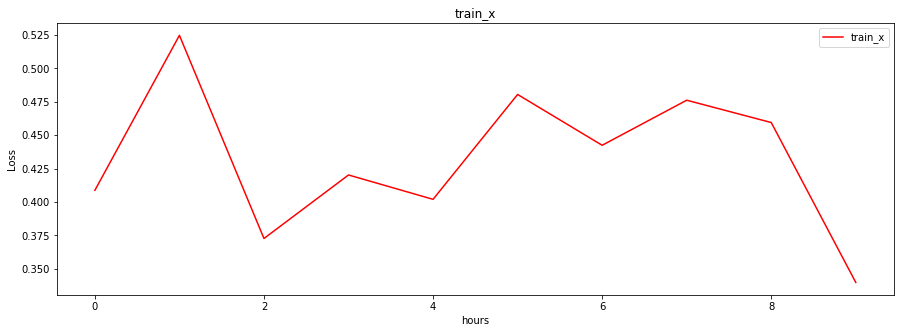

In [170]:
print(data_training_array_scaled.shape)
print(data_training_array_scaled[:10,12])
plt.figure(figsize=(15,5))
plt.plot(data_training_array_scaled[:10,12], color = 'red', label = 'train_x')
plt.title('train_x')
plt.xlabel('hours')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [171]:
data_training_y[:10]

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

### CHART MA's

(71760, 18)


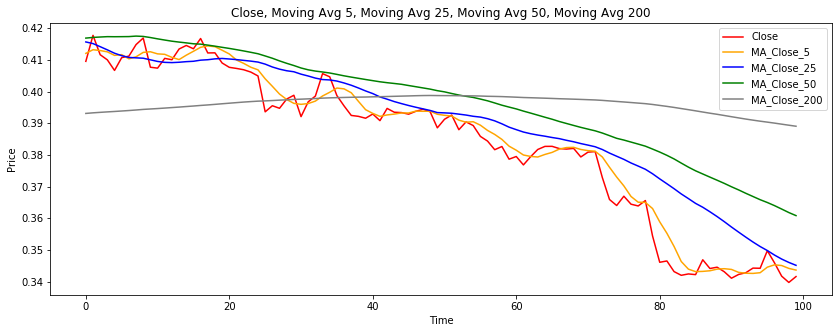

In [172]:
INICIO = 0
FIN = 100

IDX_Close = DF_Full.columns.get_loc("Close")
IDX_MA_Close_5 = DF_Full.columns.get_loc("MA_Close_5")
IDX_MA_Close_25 = DF_Full.columns.get_loc("MA_Close_25")
IDX_MA_Close_50 = DF_Full.columns.get_loc("MA_Close_50")
IDX_MA_Close_200 = DF_Full.columns.get_loc("MA_Close_200")

print(data_training_array_scaled.shape)
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_5], color = 'orange', label = 'MA_Close_5')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_25], color = 'blue', label = 'MA_Close_25')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_50], color = 'green', label = 'MA_Close_50')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_MA_Close_200], color = 'gray', label = 'MA_Close_200')
plt.title('Close, Moving Avg 5, Moving Avg 25, Moving Avg 50, Moving Avg 200')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(71760, 18)


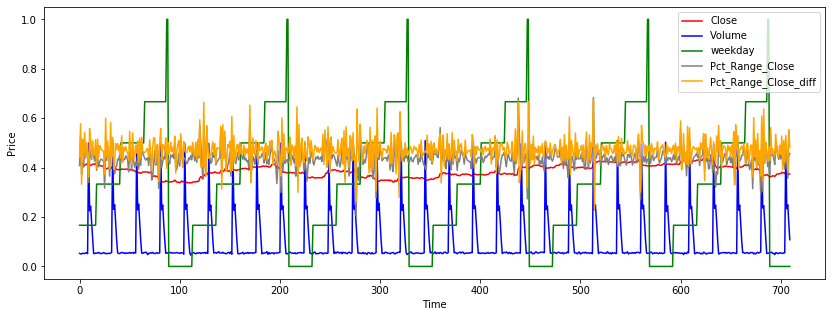

In [173]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 710


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Volume = DF_Full.columns.get_loc("Volume")
IDX_weekday = DF_Full.columns.get_loc("weekday")
IDX_Pct_Range_Close = DF_Full.columns.get_loc("Pct_Range_Close")
IDX_Pct_Range_Close_diff = DF_Full.columns.get_loc("Pct_Range_Close_diff")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Volume], color = 'blue', label = 'Volume')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_weekday], color = 'green', label = 'weekday')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close], color = 'gray', label = 'Pct_Range_Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Pct_Range_Close_diff], color = 'orange', label = 'Pct_Range_Close_diff')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

(71760, 18)


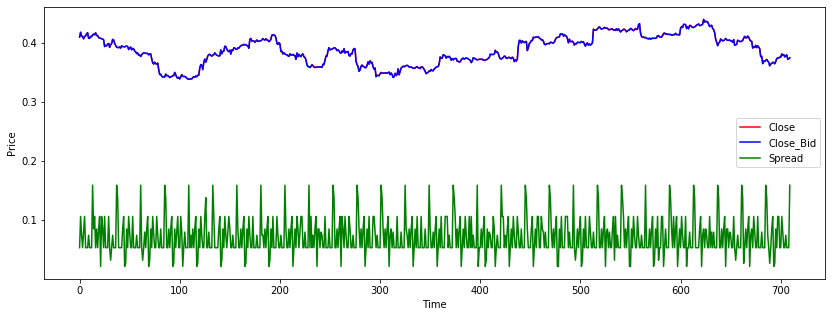

In [174]:
print(data_training_array_scaled.shape)
INICIO = 0
FIN = 710


IDX_Close = DF_Full.columns.get_loc("Close")
IDX_Close_Bid = DF_Full.columns.get_loc("Close_Bid")
IDX_Spread = DF_Full.columns.get_loc("Spread")

plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Close_Bid], color = 'blue', label = 'Close_Bid')
pyplot.plot(data_training_array_scaled[INICIO:FIN,IDX_Spread], color = 'green', label = 'Spread')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [175]:
data_training_y

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

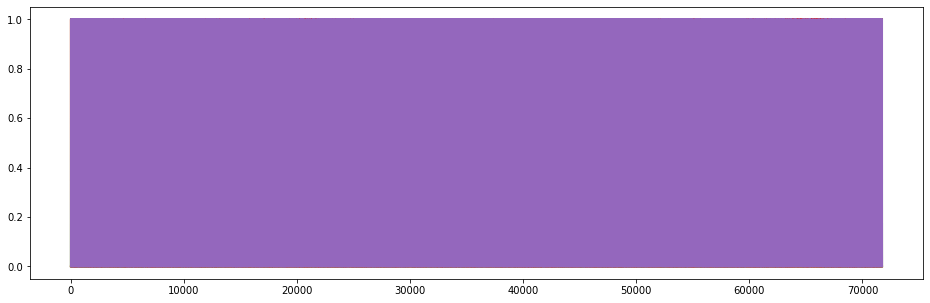

In [176]:
# Target para el entrenamiento
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)

In [303]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    indx_start = i-RANGE
    X_train.append(data_training_array_scaled[indx_start:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(71736, 24, 18)
(71736, 5)


In [298]:
X_train_np[0,:,3]

array([0.40956007, 0.4177704 , 0.41165325, 0.41002923, 0.40669097,
       0.41073297, 0.41120214, 0.41484716, 0.4169223 , 0.40770147,
       0.40741275, 0.41049839, 0.41006532, 0.41345772, 0.41457649,
       0.4135299 , 0.41677794, 0.41221264, 0.41224873, 0.40903678,
       0.40766538, 0.40732253, 0.4069075 , 0.40616767])

In [292]:
array = y_train_np[:RANGE]
uniques_y = uniques[array.argmax(1)]
print(uniques_y)

[-2.  2. -1.  2.  1. -2.  2.  1.  2. -1. -2. -2. -2.  0. -1.  1. -2.  2.
 -1.  0.  0.  1.  1. -1.]


In [178]:
#
#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

(24, 18)
(10251, 18)
<bound method NDFrame.head of           Open     High      Low    Close     Volume  Open_Bid  High_Bid  \
0      1.10977  1.11007  1.10792  1.10920  8733.5996   1.10975   1.11004   
1      1.10920  1.11055  1.10881  1.10996  7923.8901   1.10916   1.11053   
2      1.10996  1.11040  1.10949  1.11013  7694.7002   1.10994   1.11039   
3      1.11013  1.11082  1.10955  1.10964  7433.1602   1.11010   1.11081   
4      1.10966  1.11083  1.10653  1.10722  7766.4902   1.10964   1.11080   
...        ...      ...      ...      ...        ...       ...       ...   
10270  1.05742  1.05769  1.05721  1.05748  6381.8799   1.05740   1.05766   
10271  1.05748  1.05750  1.05700  1.05749  6014.2798   1.05745   1.05748   
10272  1.05749  1.05828  1.05747  1.05817  5775.6299   1.05746   1.05826   
10273  1.05816  1.05858  1.05808  1.05810  4960.8999   1.05814   1.05856   
10274  1.05811  1.05833  1.05771  1.05808  5379.8398   1.05809   1.05831   

       Low_Bid  Close_Bid  Volume_Bi

In [179]:
last_range_train_y = data_training_y[-RANGE:]
last_range_train_y

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [180]:
last_range_train_y.shape

(24, 5)

In [181]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y[-RANGE:]
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = np.concatenate((last_range_train_y,data_val_y))
print(data_val_y1.shape)
print(data_val_y1[:10])

(24, 5)
(10251, 5)
(10275, 5)
[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [182]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
print(data_val_x2[:10])

[[0.11300128 0.11028657 0.11158767 0.11153416 0.01776547 0.11318985
  0.1102924  0.11159171 0.11155831 0.01615113 0.01587302 0.66666667
  0.42472625 0.47997608 0.11223219 0.10576138 0.09876714 0.09929935]
 [0.11197301 0.11115114 0.11319833 0.11290555 0.01611833 0.11212542
  0.11117517 0.11316623 0.1129661  0.01313929 0.00529101 0.66666667
  0.45422469 0.49827938 0.11193447 0.10579729 0.09875194 0.09912484]
 [0.11334404 0.11088096 0.11442894 0.11321231 0.0156521  0.11353263
  0.11092295 0.11441499 0.11325488 0.01229756 0.01058201 0.66666667
  0.44123107 0.45949982 0.11142981 0.10592336 0.09877011 0.09896937]
 [0.11365071 0.11163746 0.11453752 0.11232812 0.01512006 0.11382128
  0.11167961 0.11450547 0.1123705  0.01419737 0.01058201 0.66666667
  0.4267103  0.4581061  0.11101228 0.10585153 0.09886915 0.09881352]
 [0.11280284 0.11165547 0.10907215 0.10796131 0.01579814 0.11299139
  0.11166159 0.109058   0.10798469 0.01270289 0.01587302 0.66666667
  0.38422622 0.43258592 0.11008282 0.1057188

In [183]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    indx_start = i-RANGE
    X_val.append(data_val_x2[indx_start:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(10251, 24, 18)
(10251, 5)


In [184]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(24, 18)
(20304, 18)


(20328, 18)

In [185]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y[-RANGE:,:]
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = np.concatenate((last_range_training_y,data_test_y))
print(data_test_y1.shape)

(24, 5)
(20304, 5)
(20328, 5)


In [186]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
print(data_test_x2[:10])

[[0.11300128 0.11028657 0.11158767 0.11153416 0.01776547 0.11318985
  0.1102924  0.11159171 0.11155831 0.01615113 0.01587302 0.66666667
  0.42472625 0.47997608 0.11223219 0.10576138 0.09876714 0.09929935]
 [0.11197301 0.11115114 0.11319833 0.11290555 0.01611833 0.11212542
  0.11117517 0.11316623 0.1129661  0.01313929 0.00529101 0.66666667
  0.45422469 0.49827938 0.11193447 0.10579729 0.09875194 0.09912484]
 [0.11334404 0.11088096 0.11442894 0.11321231 0.0156521  0.11353263
  0.11092295 0.11441499 0.11325488 0.01229756 0.01058201 0.66666667
  0.44123107 0.45949982 0.11142981 0.10592336 0.09877011 0.09896937]
 [0.11365071 0.11163746 0.11453752 0.11232812 0.01512006 0.11382128
  0.11167961 0.11450547 0.1123705  0.01419737 0.01058201 0.66666667
  0.4267103  0.4581061  0.11101228 0.10585153 0.09886915 0.09881352]
 [0.11280284 0.11165547 0.10907215 0.10796131 0.01579814 0.11299139
  0.11166159 0.109058   0.10798469 0.01270289 0.01587302 0.66666667
  0.38422622 0.43258592 0.11008282 0.1057188

In [187]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(20304, 24, 18)
(20304, 5)


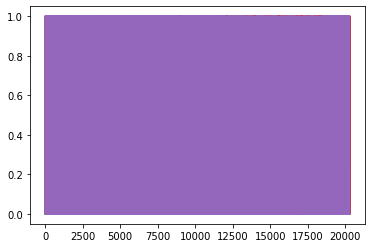

In [188]:
# Y del dataset de pruebas
pyplot.plot(y_test_np)

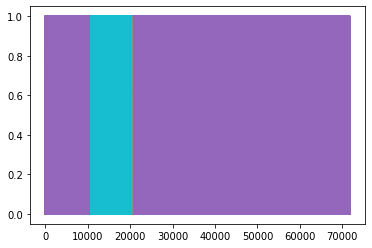

In [189]:

# Y de Val y Test comparados
pyplot.plot(y_train_np)
pyplot.plot(y_test_np)
pyplot.plot(y_val_np)


In [190]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

24
18


### Oversampling Inbalanced Class

In [341]:
#Check Current Shape
print(X_train_np.shape)
print(y_train_np.shape)

(71736, 24, 18)
(71736, 5)


In [342]:
oversample = RandomOverSampler(sampling_strategy='minority')
oversample


RandomOverSampler(sampling_strategy='minority')

In [343]:
X_over, y_over = oversample.fit_resample(X_train_np, y_train_np)

ValueError: Found array with dim 3. Estimator expected <= 2.

### BUILD LSTM MODEL 

In [445]:
model = Sequential()
model.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
model.add(LSTM(units = 40, activation = 'relu'))
model.add(Dense(units = 5, activation = 'softmax'))
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=["acc"])


In [447]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 24, 24)            4128      
_________________________________________________________________
lstm_30 (LSTM)               (None, 40)                10400     
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 205       
Total params: 14,733
Trainable params: 14,733
Non-trainable params: 0
_________________________________________________________________


In [448]:
history = model.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np),shuffle=True)

Epoch 1/100
2242/2242 [==============================] - 48s 21ms/step - loss: 0.1585 - mean_squared_error: 0.1585 - mean_absolute_error: 0.3170 - mean_absolute_percentage_error: 158521552.0000 - cosine_proximity: 0.4554 - val_loss: 0.1608 - val_mean_squared_error: 0.1608 - val_mean_absolute_error: 0.3203 - val_mean_absolute_percentage_error: 160138576.0000 - val_cosine_proximity: 0.4427
Epoch 2/100
2242/2242 [==============================] - 47s 21ms/step - loss: 0.1572 - mean_squared_error: 0.1572 - mean_absolute_error: 0.3143 - mean_absolute_percentage_error: 157160944.0000 - cosine_proximity: 0.4622 - val_loss: 0.1614 - val_mean_squared_error: 0.1614 - val_mean_absolute_error: 0.3207 - val_mean_absolute_percentage_error: 160359920.0000 - val_cosine_proximity: 0.4398
Epoch 3/100
2242/2242 [==============================] - 47s 21ms/step - loss: 0.1562 - mean_squared_error: 0.1562 - mean_absolute_error: 0.3125 - mean_absolute_percentage_error: 156233792.0000 - cosine_proximity: 0.46

Epoch 22/100
2242/2242 [==============================] - 45s 20ms/step - loss: 0.1530 - mean_squared_error: 0.1530 - mean_absolute_error: 0.3059 - mean_absolute_percentage_error: 152970912.0000 - cosine_proximity: 0.4825 - val_loss: 0.1603 - val_mean_squared_error: 0.1603 - val_mean_absolute_error: 0.3145 - val_mean_absolute_percentage_error: 157254304.0000 - val_cosine_proximity: 0.4493
Epoch 23/100
2242/2242 [==============================] - 45s 20ms/step - loss: 0.1530 - mean_squared_error: 0.1530 - mean_absolute_error: 0.3058 - mean_absolute_percentage_error: 152919120.0000 - cosine_proximity: 0.4827 - val_loss: 0.1592 - val_mean_squared_error: 0.1592 - val_mean_absolute_error: 0.3138 - val_mean_absolute_percentage_error: 156882528.0000 - val_cosine_proximity: 0.4536
Epoch 24/100
2242/2242 [==============================] - 45s 20ms/step - loss: 0.1529 - mean_squared_error: 0.1529 - mean_absolute_error: 0.3058 - mean_absolute_percentage_error: 152892928.0000 - cosine_proximity: 0

Epoch 43/100
2242/2242 [==============================] - 45s 20ms/step - loss: 0.1521 - mean_squared_error: 0.1521 - mean_absolute_error: 0.3041 - mean_absolute_percentage_error: 152074016.0000 - cosine_proximity: 0.4867 - val_loss: 0.1671 - val_mean_squared_error: 0.1671 - val_mean_absolute_error: 0.3164 - val_mean_absolute_percentage_error: 158220864.0000 - val_cosine_proximity: 0.4219
Epoch 44/100
2242/2242 [==============================] - 45s 20ms/step - loss: 0.1520 - mean_squared_error: 0.1520 - mean_absolute_error: 0.3039 - mean_absolute_percentage_error: 151959312.0000 - cosine_proximity: 0.4870 - val_loss: 0.1629 - val_mean_squared_error: 0.1629 - val_mean_absolute_error: 0.3151 - val_mean_absolute_percentage_error: 157548848.0000 - val_cosine_proximity: 0.4378
Epoch 45/100
2242/2242 [==============================] - 45s 20ms/step - loss: 0.1520 - mean_squared_error: 0.1520 - mean_absolute_error: 0.3040 - mean_absolute_percentage_error: 151980976.0000 - cosine_proximity: 0

Epoch 64/100
2242/2242 [==============================] - 45s 20ms/step - loss: 0.1513 - mean_squared_error: 0.1513 - mean_absolute_error: 0.3025 - mean_absolute_percentage_error: 151262288.0000 - cosine_proximity: 0.4903 - val_loss: 0.1619 - val_mean_squared_error: 0.1619 - val_mean_absolute_error: 0.3124 - val_mean_absolute_percentage_error: 156193680.0000 - val_cosine_proximity: 0.4447
Epoch 65/100
2242/2242 [==============================] - 45s 20ms/step - loss: 0.1513 - mean_squared_error: 0.1513 - mean_absolute_error: 0.3025 - mean_absolute_percentage_error: 151271040.0000 - cosine_proximity: 0.4902 - val_loss: 0.1617 - val_mean_squared_error: 0.1617 - val_mean_absolute_error: 0.3133 - val_mean_absolute_percentage_error: 156627504.0000 - val_cosine_proximity: 0.4445
Epoch 66/100
2242/2242 [==============================] - 45s 20ms/step - loss: 0.1513 - mean_squared_error: 0.1513 - mean_absolute_error: 0.3024 - mean_absolute_percentage_error: 151192368.0000 - cosine_proximity: 0

Epoch 85/100
2242/2242 [==============================] - 49s 22ms/step - loss: 0.1508 - mean_squared_error: 0.1508 - mean_absolute_error: 0.3015 - mean_absolute_percentage_error: 150744368.0000 - cosine_proximity: 0.4924 - val_loss: 0.1620 - val_mean_squared_error: 0.1620 - val_mean_absolute_error: 0.3141 - val_mean_absolute_percentage_error: 157065744.0000 - val_cosine_proximity: 0.4430
Epoch 86/100
2242/2242 [==============================] - 45s 20ms/step - loss: 0.1509 - mean_squared_error: 0.1509 - mean_absolute_error: 0.3017 - mean_absolute_percentage_error: 150828976.0000 - cosine_proximity: 0.4920 - val_loss: 0.1640 - val_mean_squared_error: 0.1640 - val_mean_absolute_error: 0.3146 - val_mean_absolute_percentage_error: 157291568.0000 - val_cosine_proximity: 0.4349
Epoch 87/100
2242/2242 [==============================] - 45s 20ms/step - loss: 0.1507 - mean_squared_error: 0.1507 - mean_absolute_error: 0.3012 - mean_absolute_percentage_error: 150612960.0000 - cosine_proximity: 0

In [ ]:
print(history.history.keys())

In [191]:
pwd = os.getcwd()
source_data = os.path.join(pwd, r'../../../Models/2020/LSTM/')
print(source_data)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models_clasification/../../../Models/2020/LSTM/


In [192]:
file_name = MODEL_NAME + '_' + FRECUENCIA + '_' + str(NUM_FEATURES) + 'F_' + TARGET_NAME + "_"+ ID + '.hdf5'
print(file_name)



C-LSTM_1H_23F_Class_01.hdf5


In [464]:
model.save(source_data + file_name)

In [449]:
#def baseline_model():
#    model.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
#    model.add(LSTM(units = 5, activation = 'softmax'))
#    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=["acc"])
#    #model.summary()
#    return model

In [450]:
#estimator = KerasClassifier(build_fn=baseline_model, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)
#kfold = KFold(n_splits=2, shuffle=True)

In [451]:
#results = cross_val_score(estimator, X_train_np, y_train_np, cv=kfold)

In [452]:
#print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [454]:
#Model check pointer para almacenar el modelo cada epoca

#checkpointer = ModelCheckpoint(filepath=source_data + '/model-{epoch:02d}.hdf5', verbose=1)

In [458]:
#%%time
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np), callbacks=[checkpointer], shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np),shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)

#history = model.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)





In [ ]:
#PLOT MSE MAE

#plt.figure(figsize=(5,5))
#plt.plot(history.history['loss'], color = 'red', label = 'loss')
#plt.title('Loss Model')
#plt.xlabel('Epochs')
#plt.ylabel('Loss')
#plt.legend()
#plt.show()

In [ ]:
#PLOT MSE MAE
#plt.figure(figsize=(5,5))
#plt.plot(history.history['mean_squared_error'][:], color = 'green', label = 'MAPE')
#plt.title('Loss Model')
#plt.xlabel('Epochs')
#plt.ylabel('Loss - MSE')
#plt.legend()
#plt.show()


In [193]:
#Load Model
filepath = os.path.join(source_data, file_name)
print(filepath)
model = tf.keras.models.load_model(filepath)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/models_clasification/../../../Models/2020/LSTM/C-LSTM_1H_23F_Class_01.hdf5


In [194]:
def precision(label, confusion_matrix):
    #print('label',label)
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

### CONFUSION MATRIX TEST

In [195]:
#TEST
y_test_pred = model.predict(X_test_np)
print(X_test_np.shape)

print(y_test_pred.shape)
print(y_test_np.shape)

(20304, 24, 18)
(20304, 5)
(20304, 5)


In [196]:
ID = 4
print(y_test_pred[ID])
print(y_test_np[:ID])

[1. 0. 0. 0. 0.]
[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]


In [197]:
uniques_y_test_pred = uniques[y_test_pred.argmax(1)]
uniques_y_test_np = uniques[y_test_np.argmax(1)]
print(uniques_y_test_pred)
print(uniques_y_test_pred.shape)
print(uniques_y_test_np)
print(uniques_y_test_np.shape)

[ 2. -2. -2. ...  0. -2.  2.]
(20304,)
[ 1. -2.  2. ...  0.  1.  0.]
(20304,)


In [198]:
print(uniques)

[-2. -1.  0.  1.  2.]


In [199]:
conf_matrix_test = confusion_matrix(uniques_y_test_np, uniques_y_test_pred)
conf_matrix_test

array([[ 282,   14, 1459,    6,  589],
       [ 555,   20, 2540,    9, 1190],
       [ 800,   38, 4059,   16, 1996],
       [ 523,   26, 2666,    9, 1215],
       [ 275,   15, 1379,    1,  622]])

In [200]:
print("indx Value Precision Recall")
for label in uniques:
    indx = int(np.where(uniques == label)[0])
    print (indx)
    print(f"{int(label):5d}    {precision(indx, conf_matrix_test):9.3f}    {recall(indx, conf_matrix_test):6.3f}")

indx Value Precision Recall
0
   -2        0.116     0.120
1
   -1        0.177     0.005
2
    0        0.335     0.587
3
    1        0.220     0.002
4
    2        0.111     0.271


In [201]:
print("precision total:", precision_macro_average(conf_matrix_test))
print("recall total:", recall_macro_average(conf_matrix_test))

precision total: 0.19170395133610682
recall total: 0.19710736662595912


In [202]:
accuracy(conf_matrix_test)

0.2458628841607565

### CONFUSION MATRIX TRAIN

In [203]:
#TRAIN
y_train_pred = model.predict(X_train_np)
print(X_train_np.shape)

print(y_train_pred.shape)
print(y_train_np.shape)

(71736, 24, 18)
(71736, 5)
(71736, 5)


In [204]:
ID = 4
print(y_train_pred[:ID])
print(y_train_np[:ID])

[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]
[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [205]:
uniques_y_train_pred = uniques[y_train_pred.argmax(1)]
uniques_y_train_np = uniques[y_train_np.argmax(1)]
print(uniques_y_train_pred)
print(uniques_y_train_pred.shape)
print(uniques_y_train_np)
print(uniques_y_train_np.shape)

[ 0.  0.  2. ...  2.  2. -2.]
(71736,)
[-2.  2. -1. ... -2. -2.  2.]
(71736,)


In [206]:
print(uniques)

[-2. -1.  0.  1.  2.]


In [207]:
conf_matrix_train = confusion_matrix(uniques_y_train_np, uniques_y_train_pred)
conf_matrix_train

array([[ 542,   12, 7051,   26, 4784],
       [ 609,   13, 7577,   23, 5810],
       [ 804,   15, 9431,   19, 8356],
       [ 678,   14, 7606,   27, 5918],
       [ 564,   14, 6891,   17, 4935]])

In [208]:
print("indx Value Precision Recall")
for label in uniques:
    indx = int(np.where(uniques == label)[0])
    print (indx)
    print(f"{int(label):5d}    {precision(indx, conf_matrix_train):9.3f}    {recall(indx, conf_matrix_train):6.3f}")

indx Value Precision Recall
0
   -2        0.170     0.044
1
   -1        0.191     0.001
2
    0        0.245     0.506
3
    1        0.241     0.002
4
    2        0.166     0.397


In [209]:
print("precision total:", precision_macro_average(conf_matrix_train))
print("recall total:", recall_macro_average(conf_matrix_train))

precision total: 0.20239488874225947
recall total: 0.1900304820446618


In [210]:
accuracy(conf_matrix_train)

0.20837515334002454

### TEST RESULTS TO CSV

In [211]:
print("data_test.shape: ", data_test.shape)


data_test.shape:  (20304, 18)


In [212]:
data_test_res = data_test
data_test_res.reset_index(drop=True, inplace=True)
results_data_test = pd.DataFrame(data_test_res['Open'])
results_data_test['High'] = data_test_res['High']
results_data_test['Low'] = data_test_res['Low']
results_data_test['Close'] = data_test_res['Close']
results_data_test['Volume'] = data_test_res['Volume']
print(results_data_test)

          Open     High      Low    Close      Volume
0      1.05809  1.05898  1.05769  1.05892   6150.9399
1      1.05891  1.05986  1.05847  1.05958  11677.7197
2      1.05957  1.06041  1.05744  1.05765  15785.2197
3      1.05765  1.05956  1.05708  1.05935  14816.4902
4      1.05934  1.05946  1.05835  1.05927  10641.8301
...        ...      ...      ...      ...         ...
20299  1.10998  1.11070  1.10862  1.10998  12120.8398
20300  1.10997  1.11094  1.10982  1.11071   4646.7427
20301  1.11213  1.11217  1.11136  1.11141    417.4906
20302  1.11138  1.11148  1.11028  1.11123   4549.1167
20303  1.11123  1.11199  1.11119  1.11158   5159.8101

[20304 rows x 5 columns]


In [213]:
uniques_y_test_pred[:]

array([ 2., -2., -2., ...,  0., -2.,  2.])

In [214]:

uniques_y_test_pred_pd = pd.DataFrame({'Real_Class': uniques_y_test_pred[:]})
print(uniques_y_test_pred_pd)

       Real_Class
0             2.0
1            -2.0
2            -2.0
3            -2.0
4            -2.0
...           ...
20299         0.0
20300         0.0
20301         0.0
20302        -2.0
20303         2.0

[20304 rows x 1 columns]


In [215]:
results_data_test['Real_Class'] = uniques_y_test_np
results_data_test['Predicted_Class'] = uniques_y_test_pred_pd

In [216]:
results_data_test.head(10)

,Open,High,Low,Close,Volume,Real_Class,Predicted_Class
0,1.05809,1.05898,1.05769,1.05892,6150.9399,1.0,2.0
1,1.05891,1.05986,1.05847,1.05958,11677.7197,-2.0,-2.0
2,1.05957,1.06041,1.05744,1.05765,15785.2197,2.0,-2.0
3,1.05765,1.05956,1.05708,1.05935,14816.4902,0.0,-2.0
4,1.05934,1.05946,1.05835,1.05927,10641.8301,2.0,-2.0
5,1.05925,1.06104,1.05890,1.06081,13180.9697,0.0,0.0
6,1.06082,1.06181,1.06036,1.06089,14419.7803,1.0,0.0
7,1.06092,1.06179,1.06055,1.06139,15307.1904,-2.0,2.0
8,1.06136,1.06153,1.05658,1.05724,25968.0293,-1.0,2.0
9,1.05719,1.05900,1.05668,1.05668,19795.0098,2.0,0.0


### Test Result Save CSV File 

In [219]:
file_name = MODEL_NAME + '_' + FRECUENCIA + '_' + str(NUM_FEATURES) + 'F_' + TARGET_NAME + "_Test_Results_" + ID + '.csv'
print(file_name)

C-LSTM_1H_0F_Class_Test_Results_01.csv


In [220]:
pwd = os.getcwd()
filename_path = os.path.join(pwd, r'../../../Results/LSTM/' + file_name)
results_data_test.to_csv(filename_path, header=True, index=False)

### TRAIN RESULTS TO CSV

In [270]:
print("data_train.shape: ", data_training.shape)


data_train.shape:  (71760, 18)


In [304]:
data_training_res = data_training
data_training_res.reset_index(drop=True, inplace=True)
results_data_train = pd.DataFrame(data_training_res['Open'])
results_data_train['High'] = data_training_res['High']
results_data_train['Low'] = data_training_res['Low']
results_data_train['Close'] = data_training_res['Close']
results_data_train['Volume'] = data_training_res['Volume']
print(results_data_train)
print(results_data_train.shape)
results_data_train = results_data_train.iloc[RANGE:]
results_data_train.reset_index(drop=True, inplace=True)
print(results_data_train.shape)

          Open     High      Low    Close      Volume
0      1.27584  1.27666  1.27351  1.27436  25980.0000
1      1.27435  1.27891  1.27331  1.27891  24881.5996
2      1.27890  1.27957  1.27550  1.27552  24909.9004
3      1.27523  1.27566  1.27374  1.27462  26329.6992
4      1.27465  1.27482  1.27195  1.27277  25984.5000
...        ...      ...      ...      ...         ...
71755  1.10562  1.10834  1.10450  1.10817  14604.0801
71756  1.10816  1.10957  1.10590  1.10626  11650.4600
71757  1.10626  1.10660  1.10445  1.10487  10436.1201
71758  1.10488  1.10517  1.10226  1.10318  10938.0596
71759  1.10319  1.10389  1.10084  1.10125  10399.9805

[71760 rows x 5 columns]
(71760, 5)
(71736, 5)


In [305]:
print(uniques_y_train_pred[:])
print(uniques_y_train_pred.shape)

[ 0.  0.  2. ...  2.  2. -2.]
(71736,)


In [306]:

uniques_y_train_pred_pd = pd.DataFrame({'Real_Class': uniques_y_train_pred[:]})
print(uniques_y_train_pred_pd)
print(uniques_y_train_pred_pd.shape)


       Real_Class
0             0.0
1             0.0
2             2.0
3             0.0
4             0.0
...           ...
71731         2.0
71732         2.0
71733         2.0
71734         2.0
71735        -2.0

[71736 rows x 1 columns]
(71736, 1)


In [307]:
results_data_train['Real_Class'] = uniques_y_train_np
results_data_train['Predicted_Class'] = uniques_y_train_pred_pd

In [308]:
results_data_train.head(10)
#results_data_train.tail(10)

,Open,High,Low,Close,Volume,Real_Class,Predicted_Class
0,1.27248,1.27401,1.27145,1.27180,27724.0996,-2.0,0.0
1,1.27114,1.27148,1.26514,1.26552,26449.0996,2.0,0.0
2,1.26545,1.26867,1.26503,1.26659,25657.0996,-1.0,2.0
3,1.26685,1.26744,1.26563,1.26614,25345.3008,2.0,0.0
4,1.26619,1.26832,1.26559,1.26776,25950.4004,1.0,0.0
5,1.26775,1.26903,1.26697,1.26842,25898.0996,-2.0,2.0
6,1.26823,1.26985,1.26296,1.26468,25883.6992,2.0,2.0
7,1.26436,1.26743,1.26398,1.26727,26862.1992,1.0,0.0
8,1.26706,1.26921,1.26536,1.26828,27650.5996,2.0,0.0
9,1.26830,1.27318,1.26691,1.27221,244622.4063,-1.0,0.0


In [310]:
uniques_y_train_np[:20]

array([-2.,  2., -1.,  2.,  1., -2.,  2.,  1.,  2., -1., -2., -2., -2.,
        0., -1.,  1., -2.,  2., -1.,  0.])

### Test Result Save CSV File 

In [311]:
file_name = MODEL_NAME + '_' + FRECUENCIA + '_' + str(NUM_FEATURES) + 'F_' + TARGET_NAME + "_Train_Results_" + ID + '.csv'
print(file_name)

C-LSTM_1H_0F_Class_Train_Results_01.csv


In [312]:
pwd = os.getcwd()
filename_path = os.path.join(pwd, r'../../../Results/LSTM/' + file_name)
results_data_train.to_csv(filename_path, header=True, index=False)

### CHARTS

In [156]:
y_test_np.shape

(20304, 5)

In [ ]:
INICIO = 0
FIN = 280
print(y_test_np.shape)
print(y_test_pred.shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_test_pred[INICIO:FIN], color = 'blue', label = 'Predicted')
plt.title('Prediction - Test dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
print('Test MAE:', mean_absolute_error(y_test_np, y_test_pred))#Mean Absolute Error
print('Test RMSE:',np.sqrt(mean_squared_error(y_test_np, y_test_pred)))#Root Mean Squared Error
print('Test MSE:',mean_squared_error(y_test_np, y_test_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_test_np, y_test_pred))#Mean Absolute Percentaje Error


In [ ]:
print(y_train_np.shape)
INICIO = 0
FIN = 127
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_train_np[INICIO:FIN], color = 'red', label = 'Real')
plt.plot(y_train_pred[INICIO:FIN], color = 'blue', label = 'Predicted')
plt.title('Prediction - Training dataset')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
print('Train MAE:', mean_absolute_error(y_train_np, y_train_pred))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(y_train_np, y_train_pred)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(y_train_np, y_train_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_train_np, y_train_pred))#Mean Absolute Percentaje Error
